(ch_pyTrends)=
# Trend analysis

## Packages

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import theilslopes, kendalltau
from sklearn import linear_model, metrics

## Example

<div><img src="figs/co2_data_mlo.png" width=600/></div>

Source: https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html

In [6]:
hdr = ["year", "month", "decimal_date", "average", "interpolated", "trend", "days"]
fname = "figs/co2_mm_mlo.txt"
co2 = pd.read_csv(fname, comment='#', delim_whitespace=True, names=hdr, na_values=[-99.99, -1])
co2 = co2[co2.year > 2005]
co2.head()

year  month  decimal_date  average  interpolated   trend  days
574  2006      1      2006.042   381.38        381.38  381.14  24.0
575  2006      2      2006.125   382.19        382.19  381.39  25.0
576  2006      3      2006.208   382.67        382.67  381.14  30.0
577  2006      4      2006.292   384.61        384.61  381.91  25.0
578  2006      5      2006.375   385.03        385.03  381.87  24.0

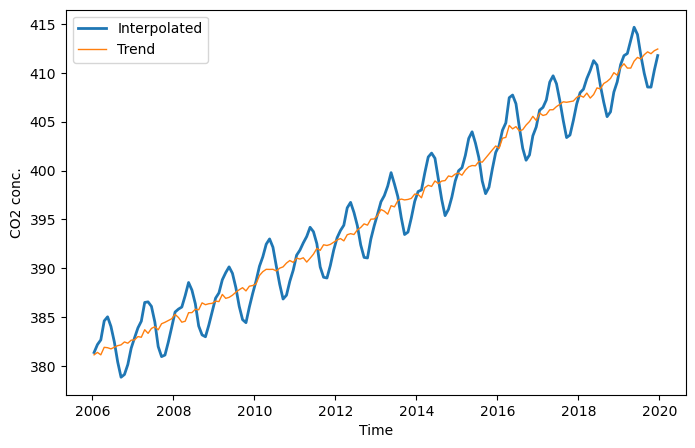

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(co2.decimal_date, co2.interpolated, '-', lw=2, label="Interpolated")
plt.plot(co2.decimal_date, co2.trend, '-', lw=1, label="Trend")
plt.xlabel("Time"); plt.ylabel("CO2 conc."); plt.legend(loc="best");

To estimate the average trend in $CO_2$ we could fit a linear model. In fact, there is a slight upwards curve. Thus, we could try a quadratic model (which is also a linear model), of the form:

$\hat{y}= \beta_0 + \beta_1t + \beta_2t^2 + \epsilon$

where $t$ is time (the x variable), $\hat{y}$ is the estimated $\mathbf{CO_2}$, and $\epsilon$ is the residual error.

## Linear fit

There are several solutions in python to fit linear models, e.g., `numpy.linalg.lstsq()` and `scipy.stats`. Here, we will use the familiar `scikit-learn` module. First, we instantiate a linear regression model. Second, we prepare the response variable $y$ and the predictor variables $X$.

In [8]:
ltrend = linear_model.LinearRegression()

In [9]:
n_obs = co2.interpolated.shape[0]
t = np.arange(n_obs) # simple time index for each month

y = co2.interpolated
X = np.array([t, t**2]).T # transpose
X.shape, y.shape

((168, 2), (168,))

Now lets fit the model and apply it to $X$ to obtain the fitted observations.

In [10]:
ltrend.fit(X, y)
y_fit = ltrend.predict(X)

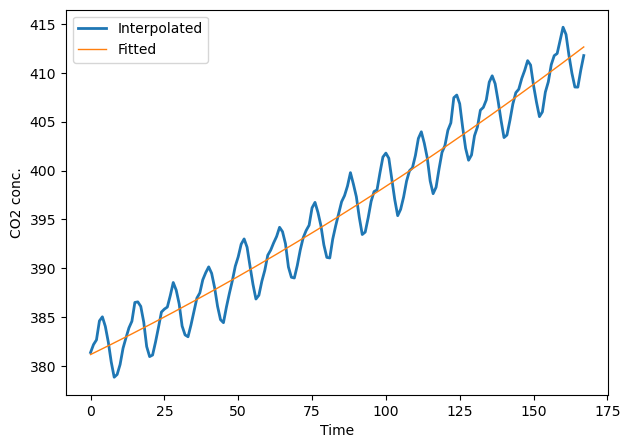

In [11]:
plt.figure(figsize=(7, 5))
plt.plot(t, co2.interpolated, '-', lw=2, label="Interpolated")
plt.plot(t, y_fit, '-', lw=1, label="Fitted")
plt.xlabel("Time"); plt.ylabel("CO2 conc."); plt.legend(loc="best");

## Harmonic model

The Fourier decomposition of a series is a matter of explaining the series entirely as a composition of sinusoidal functions.

$$\hat{y}(t) = \alpha_0 + \alpha_1 t + \sum_{n=1}^{N}\left( \beta_n cos(2\pi n \frac{t}{T}) + \gamma_n  sin(2\pi n \frac{t}{T}) \right)$$

where $\alpha$, $\beta$, and $\gamma$ are the parameters, $t$ is time, $T$ is the period of the seasonality ($T=1$ if $t$ is years, $T=12$ if $t$ is months). $n$ is the order of the harmonic function. For example, a first-order harmonic model may look like this ($n$=1). We rename all parameters as $\beta$'s out of convenience:

$$\hat{y}(t) = \beta_0 + \beta_1 t + \beta_2 cos(2\pi \frac{t}{T}) + \beta_3  sin(2\pi \frac{t}{T})$$

A second-order harmonic model may look like this:

$$\hat{y}(t) = \beta_0 + \beta_1 t + \beta_2 cos(2\pi \frac{t}{T}) + \beta_3  sin(2\pi \frac{t}{T}) + \beta_4 cos(4\pi \frac{t}{T}) + \beta_5  sin(4\pi \frac{t}{T})$$

For the $CO_2$ study, we go with a first-order harmonic model and include a quaratic term for the trend:

$$\hat{y}(t) = \beta_0 + \beta_1 t + \beta_2 {t}^2 + \beta_3 cos(2\pi \frac{t}{T}) + \beta_4  sin(2\pi \frac{t}{T})$$

In [12]:
period = 12.
t = np.arange(1, n_obs+1)
X = np.array([t, 
              t * t,
              np.cos(2.0 * np.pi * (t / period)),
              np.sin(2.0 * np.pi * (t / period))]).T
y = co2.interpolated
X.shape, y.shape

((168, 4), (168,))

In [13]:
lharm = linear_model.LinearRegression()
lharm.fit(X, y)

LinearRegression()

In [14]:
y_fit_harmonic = lharm.predict(X)
metrics.r2_score(co2.interpolated, y_fit_harmonic)

0.9938656355885715

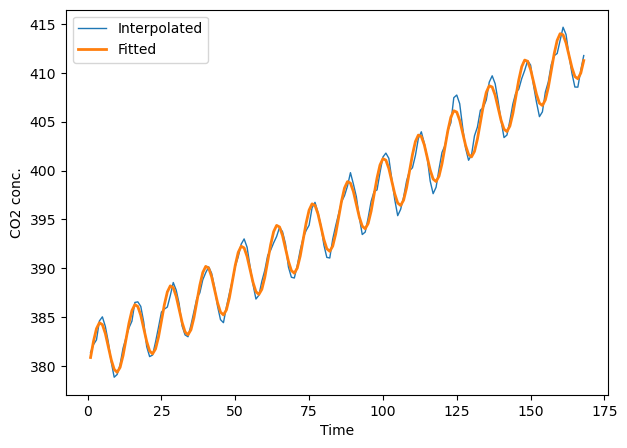

In [15]:
plt.figure(figsize=(7, 5))
plt.plot(t, co2.interpolated, '-', lw=1, label="Interpolated")
plt.plot(t, y_fit_harmonic, '-', lw=2, label="Fitted")
plt.xlabel("Time"); plt.ylabel("CO2 conc."); plt.legend(loc="best");

We can also extract the parameters for the linear trend ($t$ and $t^2$), i.e., the first and second coefficient returned by the linear model. Together with the intercept, we have everything we need to fit and plot the trend line.

In [16]:
lharm.intercept_

380.83117445676606

In [17]:
lharm.coef_

array([ 1.49280581e-01,  2.45669716e-04, -1.59397685e+00,  2.53655291e+00])

In [18]:
def fit_trend(t, a0, a1, a2):
    result = a0 + a1*t + a2*t*t
    return result
fitted_trend = fit_trend(t, lharm.intercept_, lharm.coef_[0], 
                         lharm.coef_[1])

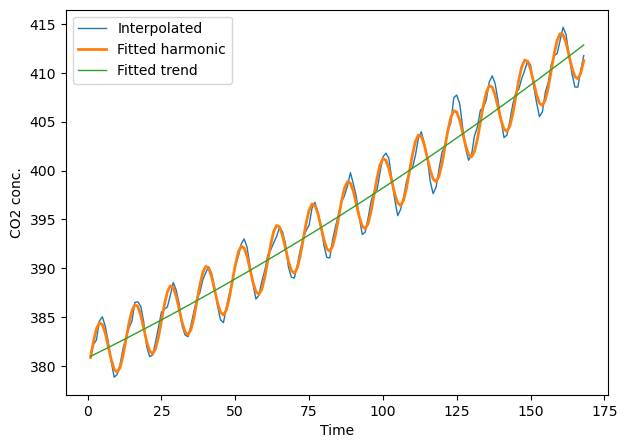

In [19]:
plt.figure(figsize=(7, 5))
plt.plot(t, co2.interpolated, '-', lw=1, label="Interpolated")
plt.plot(t, y_fit_harmonic, '-', lw=2, label="Fitted harmonic")
plt.plot(t, fitted_trend, '-', lw=1, label="Fitted trend")
plt.xlabel("Time"); plt.ylabel("CO2 conc."); plt.legend(loc="best");

## Non-linear fitting

Alternatively, [`scipy.optimize.curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) provides a way to do non-linear least squares fitting of a function. Usually, this applies to non-linear functions, e.g., double logistic. Here, we test it to the harmonic model (which usually is better fit with a linear solver - but let's do it for the sake of comparison). If you are unsure about the `*` in `*p_opt`, then read *Packing and unpacking* in chapter [Think python](ch_thinkPython).

In [20]:
def trend_with_harmonic(t, a0, a1, a2, a3, a4, period=12.):
    result = a0 + a1*t + a2*t*t + \
             a3 * np.cos(2 * np.pi * (t / period)) + \
             a4 * np.sin(2 * np.pi * (t / period))
    return result

x = np.arange(1, n_obs+1)
y = co2.interpolated

p_opt, p_cov = curve_fit(trend_with_harmonic, x, y, np.ones(5))
y_fit_harmonic2 = trend_with_harmonic(x, *p_opt)

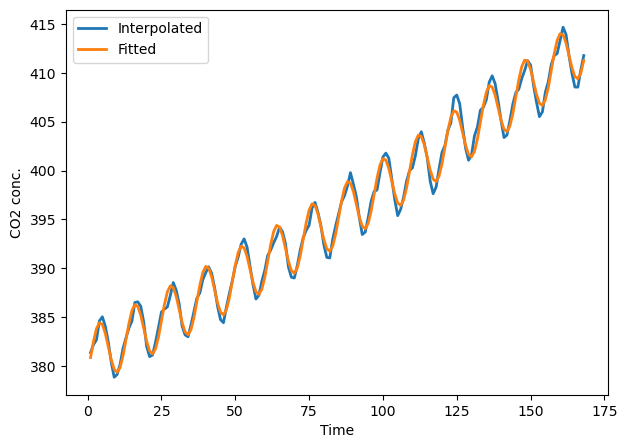

In [21]:
plt.figure(figsize=(7, 5))
plt.plot(x, co2.interpolated, '-', lw=2, label="Interpolated")
plt.plot(x, y_fit_harmonic2, '-', lw=2, label="Fitted")
plt.xlabel("Time"); plt.ylabel("CO2 conc."); plt.legend(loc="best");

## Non-Parametric Trend Analysis
### Sen's slope

In non-parametric statistics, the Theil–Sen estimator is a method for robustly fitting a line to sample points in the plane (simple linear regression) by choosing the median of the slopes of all lines through pairs of points ([wikipedia](https://en.wikipedia.org/wiki/Theil–Sen_estimator)). The estimator is insensitive to outliers and can be more accurate than non-robust simple linear regression (least squares) for skewed and heteroskedastic data. As a result the Sen slope has been very popular for estimating linar trends. Sen's slope is often combined with the non-parametric Mann-Kendall test for the presence of an increasing or decreasing trend.

In [22]:
slope, intercept, low_slope, high_slope = theilslopes(y, t)
slope, intercept, low_slope, high_slope

(0.18833333333333258,
 379.2658333333334,
 0.180416666666666,
 0.19608108108108172)

### Mann-Kendall test

Sen's slope is often combined with the non-parametric **Mann-Kendall** test for the presence of an increasing or decreasing trend. Kendall’s tau is a measure of the correspondence between two rankings. Values close to 1 indicate strong agreement, and values close to -1 indicate strong disagreement. 

In [23]:
tau, p_value = kendalltau(t, y)
tau, p_value

(0.8496471113057769, 4.534646958423809e-60)